## Neural population dynamics

This is the code to analyze neural activity data during pertruabed reach-to-consume.
Contact liyi.start@gmail.com for more information.

## 1. Functions

In [1]:
import pickle

from sklearn.decomposition import PCA 
from scipy.spatial import procrustes
import scipy.stats as stats
import pingouin as pg

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from BasicProcessing_2P import *
from AdvancedAnalysis_2P import *


In [ ]:
# set the NAME_KEY and data_paths
NAME_KEY = 'Fezf2'
data_filename = f'G:\\{NAME_KEY}_OptoFP_2P_Spks_Sum.pkl'
mask_filename = f'G:\\{NAME_KEY}_Sortinfo.pkl'

In [3]:
# Parameters
REACH_TRIALS_PER_SESSION = 140
FS_2P = 30
FP_FRAME_NUM_2P = 2*FS_2P
WN = [-2, 7]
mpp_side = 0.1  # mm per pixel for side camera
FS_VID = 150  # frame rate of video
FRAME_SLICE = slice(45, 105)  # frame slice for 2p data
FRAME_LEN = FRAME_SLICE.stop - FRAME_SLICE.start
# Conversion factor from 2P frames to video frames
frame_ratio = FS_VID / FS_2P  # e.g., 150 / 30 = 5
# Ensure FRAME_SLICE_VID has the same length as FRAME_SLICE
FRAME_SLICE_VID = (np.arange(FRAME_SLICE.start, FRAME_SLICE.stop) * frame_ratio).astype(int)

TRIAL_BLOCKS = {
    "ctrl": np.r_[0:40, 100:140],  # Pre + Post trials
    "dev": np.r_[40:100],          # Perturbation trials
}
BLOCK_SIZE = 10  # number of trials per block for averaging
N_COMP = 4  # number of PCA components for neural data
colors = {
    'ctrl': '#a4aca7',
    'dev': '#C13C33',
    'passive': '#006d87',
    }

## 2. Load data and set parameters

In [4]:
# load session sumarized data
with open(data_filename, 'rb') as f:
    data = pickle.load(f)
    
results = data['results']  #dictionary of session results
n_sessions = len(results)

# neural cluster info
with open(mask_filename, 'rb') as f:
    clus_data = pickle.load(f)
# Example usage
keep_mask = clus_data['keep_mask']
print(keep_mask.shape)
stats_results = clus_data['stats_results']
masks = clus_data['masks']

passive_mask = masks['passive']
non_passive_mask = ~masks['passive']

(558,)


## 3. Neural trajectories

(57,)
(28,)
(37,)
(76,)
(51,)
(34,)
(42,)
(36,)
(27,)
(41,)
(61,)
(13,)
(48,)
(7,)
(558, 120)
Ctrl plane: R² = 0.918
Ctrl Plane RMSE = 2.092
Dev plane: R² = 0.267
Dev Plane RMSE = 5.818
Dev projection onto Control Plane: R² = -10.214
Procrustes similarity (ctrl vs dev): 0.926


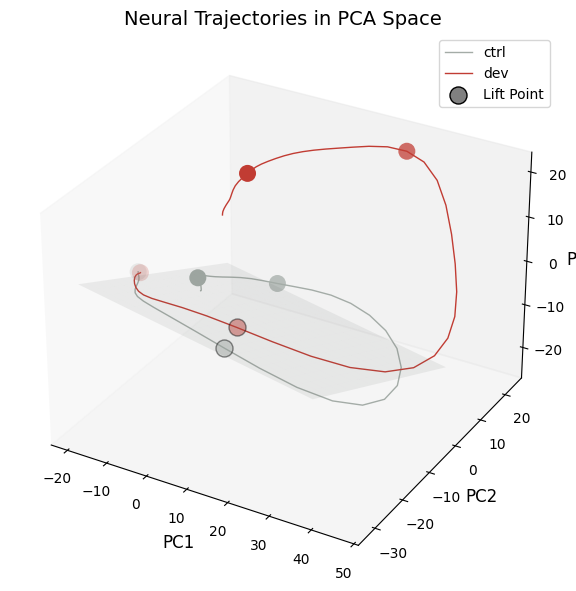

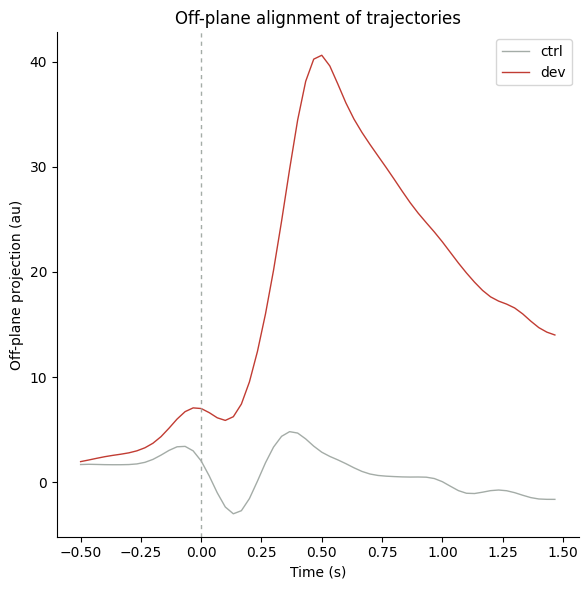

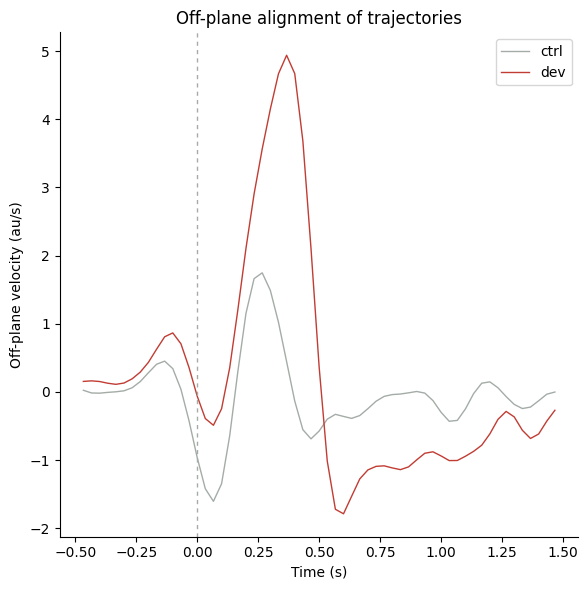

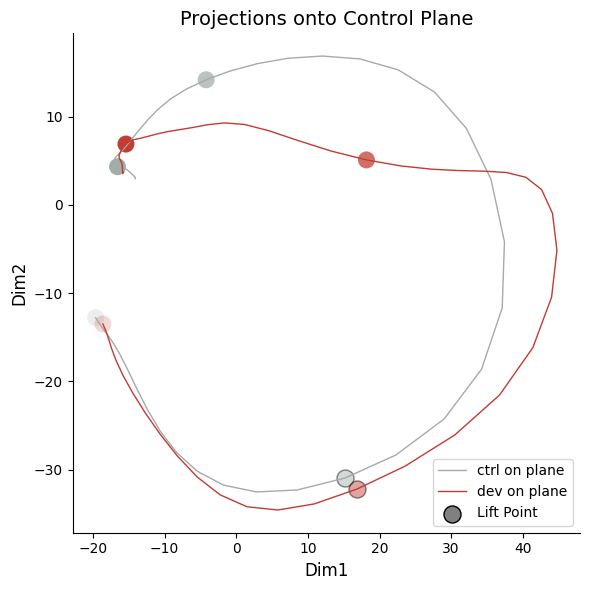

In [5]:
# Extract block results from the optimized processing results
all_block_results = {}
passive_masks_sess = {}
tmp_sidx = 0
for session, result in results.items():
    if result is not None:  # Check if session was processed successfully
        all_block_results[session] = result['blocks']
        tmp_neurons, tmp_trial_len = result['blocks']['ctrl'].shape
        tmp_eidx = tmp_sidx + tmp_neurons
        passive_masks_sess[session] = passive_mask[tmp_sidx:tmp_eidx]
        print(passive_masks_sess[session].shape)
        tmp_sidx = tmp_eidx
        
# block_results
block_results = concatenate_dict_sessions(all_block_results)


selected_keys = ['ctrl', 'dev'] # 'dev', , 'passive_dev_diff'
# selected_neurons = masks['passive'] & keep_mask
# selected_neurons = masks['non_passive'] & keep_mask
selected_neurons = keep_mask

frame_indices = np.arange(45, 105)       # original frames
FS_2P = 30  # Sampling rate in Hz
time_sec = (frame_indices - 60) / FS_2P   # seconds relative to frame 60
    
data_blocks = [block_results[key][:, FRAME_SLICE] for key in selected_keys]

# Stack along time axis: (n_neurons, n_timepoints * n_conditions)
concat_data = np.hstack(data_blocks)  # (n_neurons, T * 2)
print(concat_data.shape)

# Select neurons and transpose to shape (T * 2, n_neurons) => samples x features
concat_data_T = concat_data[selected_neurons, :].T

# Fit PCA
n_components = 3
pca = PCA(n_components=n_components)
pca_proj = pca.fit_transform(concat_data_T)  # Shape: (T * 2, 3)

# Split projections dynamically based on selected_keys
n_timepoints = data_blocks[0].shape[1]

proj_dict = {}
for i, key in enumerate(selected_keys):
    start = i * n_timepoints
    end = (i + 1) * n_timepoints
    proj_dict[key] = pca_proj[start:end]

# Example: access projections by name
ctrl_proj = proj_dict.get('ctrl')
dev_proj = proj_dict.get('dev')
passive_proj = proj_dict.get('passive_dev_diff')

# === Fit planes for dev and ctrl trajectories ===
plane_normal_ctrl, r2_ctrl, reg_ctrl, d_ctrl = fit_trk_plane(ctrl_proj)
rmse_ctrl = compute_rmse(ctrl_proj, reg_ctrl)
print(f"Ctrl plane: R² = {r2_ctrl:.3f}")
print(f"Ctrl Plane RMSE = {rmse_ctrl:.3f}")
ctrl_proj_on_plane = project_onto_plane(ctrl_proj, plane_normal_ctrl, d_ctrl)

if dev_proj is not None:
    plane_normal_dev, r2_dev, reg_dev, d_dev = fit_trk_plane(dev_proj)
    print(f"Dev plane: R² = {r2_dev:.3f}")
    rmse_dev = compute_rmse(dev_proj, reg_dev)
    print(f"Dev Plane RMSE = {rmse_dev:.3f}")
    dev_proj_on_plane = project_onto_plane(dev_proj, plane_normal_ctrl, d_ctrl)
    # Compute R² for dev trajectory on control plane
    X_dev = dev_proj[:, :2]
    z_dev = dev_proj[:, 2]
    z_dev_pred = reg_ctrl.predict(X_dev)
    r2_dev_on_ctrl_plane = reg_ctrl.score(X_dev, z_dev)
    print(f"Dev projection onto Control Plane: R² = {r2_dev_on_ctrl_plane:.3f}")
    # Procrustes similarity between projected ctrl and dev
    mtx1, mtx2, disparity = procrustes(ctrl_proj_on_plane, dev_proj_on_plane)
    procrustes_similarity = 1 - disparity
    print(f"Procrustes similarity (ctrl vs dev): {procrustes_similarity:.3f}")

if passive_proj is not None:
    plane_normal_passive, r2_passive, reg_passive, d_passive = fit_trk_plane(passive_proj)
    print(f"Passive plane: R² = {r2_passive:.3f}")

    rmse_passive = compute_rmse(passive_proj, reg_passive)
    print(f"Passive Plane RMSE = {rmse_passive:.3f}")

    passive_proj_on_plane = project_onto_plane(passive_proj, plane_normal_ctrl, d_ctrl)

    # Compute R² for passive trajectory on control plane
    X_passive = passive_proj[:, :2]
    z_passive = passive_proj[:, 2]
    r2_passive_on_ctrl_plane = reg_ctrl.score(X_passive, z_passive)
    print(f"Passive projection onto Control Plane: R² = {r2_passive_on_ctrl_plane:.3f}")

    # Procrustes similarity between projected ctrl and passive
    mtx1, mtx2, disparity = procrustes(ctrl_proj_on_plane, passive_proj_on_plane)
    procrustes_similarity_passive = 1 - disparity
    print(f"Procrustes similarity (ctrl vs passive): {procrustes_similarity_passive:.3f}")


# === Plotting plane and trajectories ===
xlim = [ctrl_proj[:, 0].min(),
        ctrl_proj[:, 0].max()]
ylim = [ctrl_proj[:, 1].min(),
        ctrl_proj[:, 1].max()]

xx, yy = np.meshgrid(
    np.linspace(xlim[0], xlim[1], 20),
    np.linspace(ylim[0], ylim[1], 20)
)
a, b = reg_ctrl.coef_ 
c = reg_ctrl.intercept_
zz = a * xx + b * yy + c

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

colors = {'ctrl': '#a4aca7', 'dev': '#C13C33', 'passive': '#006d87'}
trajectories = {'ctrl': ctrl_proj, 'dev': dev_proj, 'passive': passive_proj}
# Keep only non-None fields
trajectories = {k: v for k, v in trajectories.items() if v is not None}

# Plane surface
ax.plot_surface(xx, yy, zz, alpha=0.1, color=colors['ctrl'], edgecolor='none')

# Trajectories
for label, proj in trajectories.items():
    ax.plot(proj[:, 0], proj[:, 1], proj[:, 2], label=label, color=colors[label], linewidth=1)

# Scatter highlights
lift_pnt, step, offset = 15, 15, 0
for label, proj in trajectories.items():
    n_points = (proj.shape[0] - offset) // step
    for i in range(n_points):
        idx = offset + i * step
        alpha = 0.2 + 0.8 * (i / max(n_points - 1, 1))
        edge = 'k' if idx == lift_pnt else 'none'
        ax.scatter(proj[idx, 0], proj[idx, 1], proj[idx, 2],
                   color=colors[label], alpha=alpha, s=150,
                   edgecolor=edge, linewidth=1 if edge == 'k' else 0.5)

ax.scatter([], [], [], color='gray', s=150, edgecolor='k', linewidth=1, label='Lift Point')
ax.set_xlabel('PC1', fontsize=12)
ax.set_ylabel('PC2', fontsize=12)
ax.set_zlabel('PC3', fontsize=12)
ax.set_title('Neural Trajectories in PCA Space', fontsize=14)
ax.legend()
ax.grid(False)
# ax.view_init(elev=15, azim=-70)
plt.tight_layout()
# plt.savefig('All_Fezf2_PCA_Neural_Trajectory_Spk_activity_3D_All_Neurons.pdf', bbox_inches='tight', dpi=300)
plt.show()

# === Off-plane projection of trajectories (not velocity) ===
plt.figure(figsize=(6, 6))

# Ctrl
ctrl_out_of_plane = ctrl_proj @ plane_normal_ctrl + d_ctrl
plt.plot(time_sec, ctrl_out_of_plane, color=colors['ctrl'], linewidth=1, label='ctrl')

# Dev
if dev_proj is not None:
    dev_out_of_plane = dev_proj @ plane_normal_ctrl + d_ctrl
    plt.plot(time_sec, dev_out_of_plane, color=colors['dev'], linewidth=1, label='dev')

# Passive
if passive_proj is not None:
    passive_out_of_plane = passive_proj @ plane_normal_ctrl + d_ctrl
    plt.plot(time_sec, passive_out_of_plane, color=colors['passive'], linewidth=1, label='passive')

# Formatting
plt.axvline(0, color='#a4aca7', linestyle='--', dashes=(3, 3), linewidth=1)
plt.xlabel("Time (s)")
plt.ylabel("Off-plane projection (au)")
plt.title("Off-plane alignment of trajectories")
plt.legend()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
# plt.savefig('Fezf2_PCA_Neural_Trajectory_Spk_activity_Off_Plane_Proj_All_Neurons.pdf', bbox_inches='tight', dpi=300)
plt.show()

# === Off-plane velocity ===
ctrl_dir = np.diff(ctrl_proj, axis=0)
ctrl_dir_norm = ctrl_dir / np.linalg.norm(ctrl_dir, axis=1, keepdims=True)
ctrl_out_of_plane = np.dot(ctrl_dir, plane_normal_ctrl)
plt.figure(figsize=(6, 6))
plt.plot(time_sec[1:], ctrl_out_of_plane, color=colors['ctrl'], linewidth=1, label='ctrl')
if dev_proj is not None:
    dev_dir = np.diff(dev_proj, axis=0)
    dev_dir_norm = dev_dir / np.linalg.norm(dev_dir, axis=1, keepdims=True)
    # Projection on plane normals
    dev_out_of_plane = np.dot(dev_dir, plane_normal_ctrl)
    plt.plot(time_sec[1:], dev_out_of_plane, color=colors['dev'], linewidth=1, label='dev')

if passive_proj is not None:
    passive_dir = np.diff(passive_proj, axis=0)
    passive_dir_norm = passive_dir / np.linalg.norm(passive_dir, axis=1, keepdims=True)
    # Projection on plane normals
    passive_out_of_plane = np.dot(passive_dir, plane_normal_ctrl)
    plt.plot(time_sec[1:], passive_out_of_plane, color=colors['passive'], linewidth=1, label='passive')

plt.axvline(0, color='#a4aca7', linestyle='--', dashes=(3, 3), linewidth=1)
plt.xlabel("Time (s)")
plt.ylabel("Off-plane velocity (au/s)")
plt.title("Off-plane alignment of trajectories")
plt.legend()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
# plt.savefig('Fezf2_PCA_Neural_Trajectory_Spk_activity_Off_Plane_Vel_All_Neurons.pdf', bbox_inches='tight', dpi=300)
plt.show()

# === New 2D plot of projections onto Control Plane ===
fig2, ax2 = plt.subplots(figsize=(6, 6))

# Plot projected trajectories as lines (optional)
if ctrl_proj_on_plane is not None:
    ax2.plot(ctrl_proj_on_plane[:, 0], ctrl_proj_on_plane[:, 1],
             label='ctrl on plane', color=colors['ctrl'], linewidth=1)
if dev_proj_on_plane is not None:
    ax2.plot(dev_proj_on_plane[:, 0], dev_proj_on_plane[:, 1],
             label='dev on plane', color=colors['dev'], linewidth=1)

# Graded scatter highlights (matching 3D style)
proj_on_plane_dict = {
    'ctrl': ctrl_proj_on_plane,
    'dev': dev_proj_on_plane
}
for label, proj in proj_on_plane_dict.items():
    if proj is None:
        continue
    n_points = (proj.shape[0] - offset) // step
    for i in range(n_points):
        idx = offset + i * step
        alpha = 0.2 + 0.8 * (i / max(n_points - 1, 1))
        edge = 'k' if idx == lift_pnt else 'none'
        ax2.scatter(proj[idx, 0], proj[idx, 1],
                    color=colors[label], alpha=alpha, s=150,
                    edgecolor=edge, linewidth=1 if edge == 'k' else 0.5)

# Legend marker for lift point
ax2.scatter([], [], color='gray', s=150, edgecolor='k', linewidth=1, label='Lift Point')

# Axis formatting
ax2.set_xlabel('Dim1', fontsize=12)
ax2.set_ylabel('Dim2', fontsize=12)
ax2.set_title('Projections onto Control Plane', fontsize=14)
ax2.legend()
ax2.grid(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
# plt.savefig('All_Fezf2_PCA_Neural_Trajectory_Spk_activity_2D_All_Neurons.pdf', bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()




=== Processing Passive Responsive ===
Passive Responsive control plane: R² = 0.988
Passive Responsive dev projection on ctrl plane: R² = -3.016


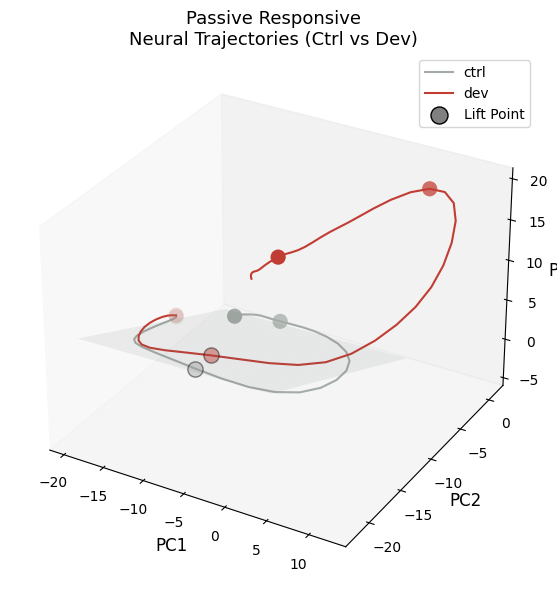

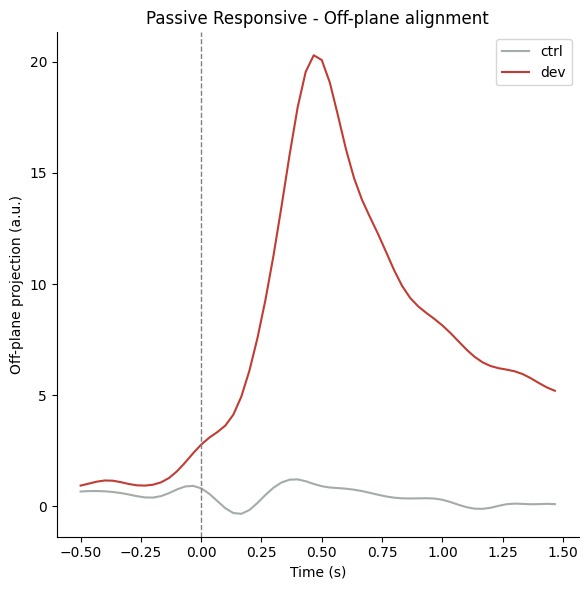

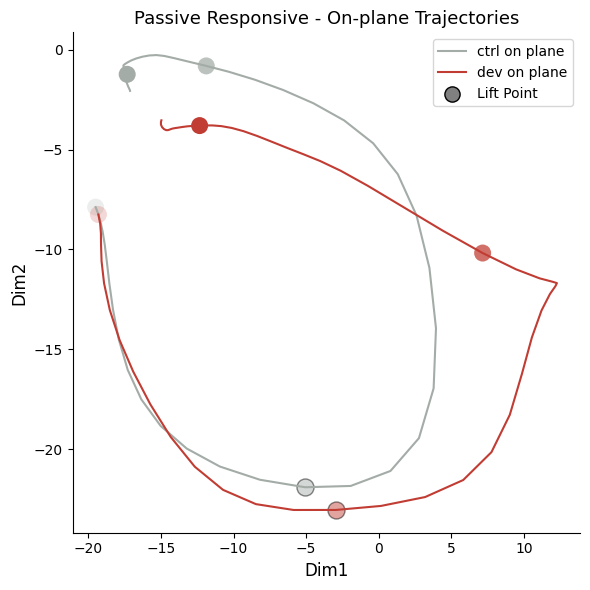


=== Processing Passive Non-Responsive ===
Passive Non-Responsive control plane: R² = 0.958
Passive Non-Responsive dev projection on ctrl plane: R² = -2.025


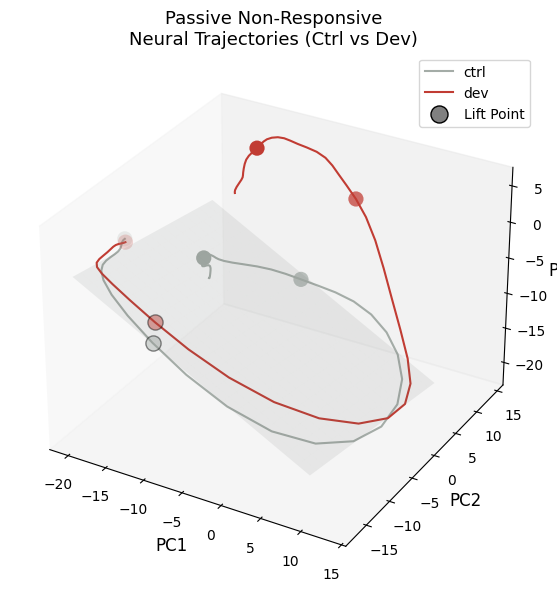

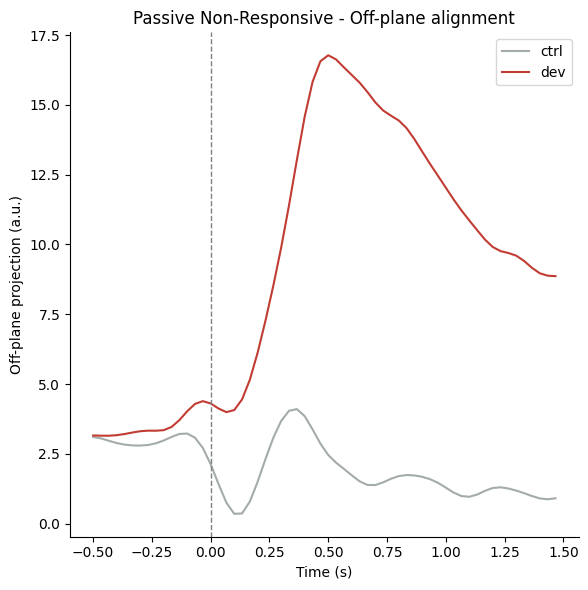

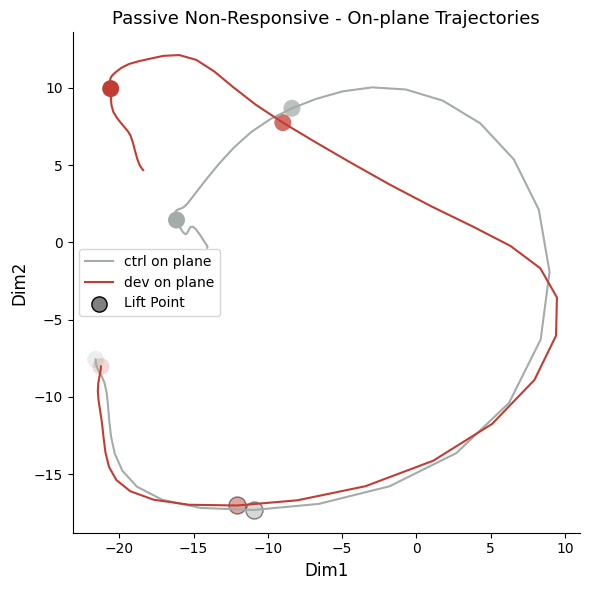

In [6]:
# --- Shared PCA fitting on all neurons (fixed space) ---
full_data = concat_data  # shape: (n_neurons, n_timepoints)
full_data_ctrd = full_data - np.mean(full_data, axis=0)

n_components = 3
pca = PCA(n_components=n_components)
pca.fit(full_data_ctrd.T)  # fit once globally

# --- Define neuron groups ---
group_names = ['Passive Responsive', 'Passive Non-Responsive']
group_masks = [passive_mask, non_passive_mask]
group_colors = ['#006d87', '#59689a']  # base color for groups

selected_keys = ['ctrl', 'dev']
colors = {'ctrl': '#a4aca7', 'dev': '#C13C33'}

# --- Loop over each neuron group ---
for group_name, group_mask, group_color in zip(group_names, group_masks, group_colors):
    print(f"\n=== Processing {group_name} ===")

    # Prepare block data for ctrl and dev
    data_blocks = [block_results[key][:, FRAME_SLICE] for key in selected_keys]
    concat_data = np.hstack(data_blocks)  # (n_neurons, T * 2)
    concat_data_T = concat_data.T  # shape (T*2, n_neurons)

    # Apply group mask (zeros outside group)
    concat_data_masked = concat_data.copy()
    concat_data_masked[~group_mask, :] = 0  # zero out non-group neurons
    pca_proj = pca.transform(concat_data_masked.T)

    # Split projections into ctrl and dev segments
    n_timepoints = data_blocks[0].shape[1]
    proj_dict = {}
    for i, key in enumerate(selected_keys):
        start = i * n_timepoints
        end = (i + 1) * n_timepoints
        proj_dict[key] = pca_proj[start:end]

    ctrl_proj = proj_dict['ctrl']
    dev_proj = proj_dict['dev']

    # --- Fit ctrl plane for this group ---
    plane_normal_ctrl, r2_ctrl, reg_ctrl, d_ctrl = fit_trk_plane(ctrl_proj)
    print(f"{group_name} control plane: R² = {r2_ctrl:.3f}")

    # Project dev trajectory onto ctrl plane
    dev_proj_on_plane = project_onto_plane(dev_proj, plane_normal_ctrl, d_ctrl)
    ctrl_proj_on_plane = project_onto_plane(ctrl_proj, plane_normal_ctrl, d_ctrl)
    X_dev = dev_proj[:, :2]
    z_dev = dev_proj[:, 2]
    r2_dev_on_ctrl_plane = reg_ctrl.score(X_dev, z_dev)
    print(f"{group_name} dev projection on ctrl plane: R² = {r2_dev_on_ctrl_plane:.3f}")

    # Compute visualization plane
    xlim = [ctrl_proj[:, 0].min(), ctrl_proj[:, 0].max()]
    ylim = [ctrl_proj[:, 1].min(), ctrl_proj[:, 1].max()]
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 20),
                         np.linspace(ylim[0], ylim[1], 20))
    a, b = reg_ctrl.coef_
    c = reg_ctrl.intercept_
    zz = a * xx + b * yy + c

    # --- Plot 3D trajectories for this group ---
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plane surface
    ax.plot_surface(xx, yy, zz, alpha=0.1, color=colors['ctrl'], edgecolor='none')

    # Plot trajectories (ctrl & dev)
    trajectories = {'ctrl': ctrl_proj, 'dev': dev_proj}
    for label, proj in trajectories.items():
        ax.plot(proj[:, 0], proj[:, 1], proj[:, 2],
                label=label, color=colors[label], linewidth=1.5)

    # Highlight lift points
    lift_pnt, step, offset = 15, 15, 0
    for label, proj in trajectories.items():
        n_points = (proj.shape[0] - offset) // step
        for i in range(n_points):
            idx = offset + i * step
            alpha = 0.2 + 0.8 * (i / max(n_points - 1, 1))
            edge = 'k' if idx == lift_pnt else 'none'
            ax.scatter(proj[idx, 0], proj[idx, 1], proj[idx, 2],
                       color=colors[label], alpha=alpha, s=120,
                       edgecolor=edge, linewidth=1 if edge == 'k' else 0.5)

    ax.scatter([], [], [], color='gray', s=150, edgecolor='k', linewidth=1, label='Lift Point')
    ax.set_xlabel('PC1', fontsize=12)
    ax.set_ylabel('PC2', fontsize=12)
    ax.set_zlabel('PC3', fontsize=12)
    ax.set_title(f'{group_name}\nNeural Trajectories (Ctrl vs Dev)', fontsize=13)
    ax.legend()
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.savefig(f'{NAME_KEY}_{group_name}_PCA_Neural_Trajectory_Spk_activity_3D.pdf', bbox_inches='tight', dpi=300)
    plt.show()

    # --- Additional Plot 1: Off-plane projection ---
    ctrl_off_plane = ctrl_proj @ plane_normal_ctrl + d_ctrl
    dev_off_plane = dev_proj @ plane_normal_ctrl + d_ctrl

    plt.figure(figsize=(6, 6))
    plt.plot(time_sec, ctrl_off_plane, color=colors['ctrl'], label='ctrl', linewidth=1.5)
    plt.plot(time_sec, dev_off_plane, color=colors['dev'], label='dev', linewidth=1.5)
    plt.axvline(0, color='gray', linestyle='--', linewidth=1)
    plt.xlabel('Time (s)')
    plt.ylabel('Off-plane projection (a.u.)')
    plt.title(f'{group_name} - Off-plane alignment')
    plt.legend()
    plt.grid(False)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.savefig(f'{NAME_KEY}_{group_name}_PCA_Neural_Trajectory_Spk_activity_Off_Plane_Proj.pdf', bbox_inches='tight', dpi=300)
    plt.show()

    # --- Additional Plot 2: On-plane 2D trajectories ---
    fig2, ax2 = plt.subplots(figsize=(6, 6))
    ax2.plot(ctrl_proj_on_plane[:, 0], ctrl_proj_on_plane[:, 1],
             color=colors['ctrl'], label='ctrl on plane', linewidth=1.5)
    ax2.plot(dev_proj_on_plane[:, 0], dev_proj_on_plane[:, 1],
             color=colors['dev'], label='dev on plane', linewidth=1.5)

    # Highlight lift points
    for label, proj in {'ctrl': ctrl_proj_on_plane, 'dev': dev_proj_on_plane}.items():
        n_points = (proj.shape[0] - offset) // step
        for i in range(n_points):
            idx = offset + i * step
            alpha = 0.2 + 0.8 * (i / max(n_points - 1, 1))
            edge = 'k' if idx == lift_pnt else 'none'
            ax2.scatter(proj[idx, 0], proj[idx, 1],
                        color=colors[label], alpha=alpha, s=150,
                        edgecolor=edge, linewidth=1 if edge == 'k' else 0.5)

    ax2.scatter([], [], color='gray', s=120, edgecolor='k', linewidth=1, label='Lift Point')
    ax2.set_xlabel('Dim1', fontsize=12)
    ax2.set_ylabel('Dim2', fontsize=12)
    ax2.set_title(f'{group_name} - On-plane Trajectories', fontsize=13)
    ax2.legend()
    ax2.grid(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.savefig(f'{NAME_KEY}_{group_name}_PCA_Neural_Trajectory_Spk_activity_On_Plane_Proj.pdf', bbox_inches='tight', dpi=300)
    plt.show()


## 4. LDA across sessions

Processing session: Fezf2GC8#329M_WR_Pos340_2X_Adaptation_Passive_Limb_LED_Stim_10Hz2s_From_Lift_6
Using first 4 components out of 4 based on variance threshold
Processing session: Fezf2GC8#329M_WR_Pos370_2X_Adaptation_Passive_Limb_LED_Stim_10Hz2s_From_Lift_3
Using first 4 components out of 4 based on variance threshold
Processing session: Fezf2GC8#329M_WR_Pos446_2X_Adaptation_Passive_Limb_LED_Stim_10Hz2s_From_Lift_7
Using first 4 components out of 4 based on variance threshold
Processing session: Fezf2GC8#329M_WR_Pos460_2X_Adaptation_Passive_Limb_LED_Stim_10Hz2s_From_Lift_4
Using first 4 components out of 4 based on variance threshold
Processing session: Fezf2GC8#329M_WR_Pos500_2X_Adaptation_Passive_Limb_LED_Stim_10Hz2s_From_Lift_5
Using first 4 components out of 4 based on variance threshold
Processing session: Fezf2GC8#329M_WR_Pos520_2X_Adaptation_Passive_Limb_LED_Stim_10Hz2s_From_Lift_8
Using first 4 components out of 4 based on variance threshold
Processing session: Fezf2GC8#332M_

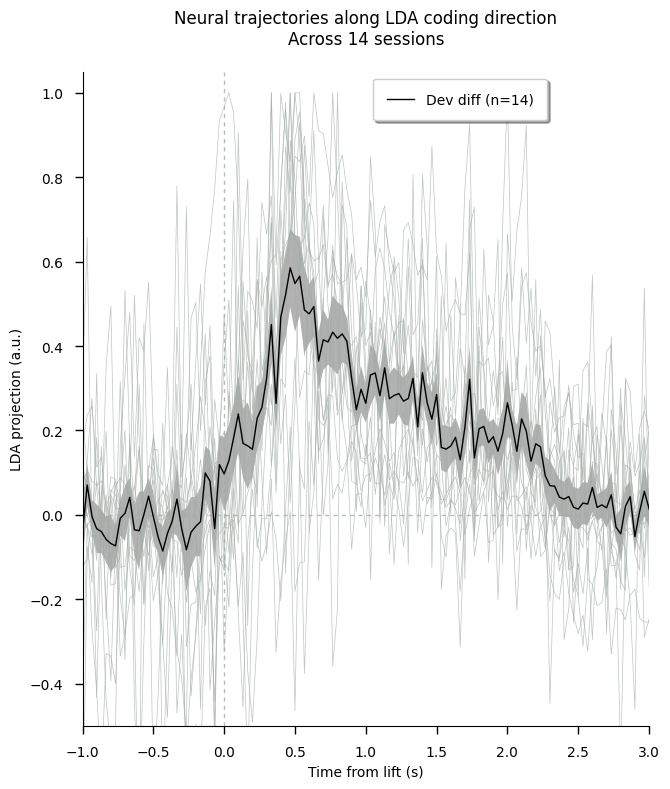


Processed 14 valid sessions


In [7]:
# Colors for average traces
avg_pert_color = '#C13C33'  # Rich crimson red
avg_ctrl_color = '#59689a' # DarkGreen #'#3C5840'  # Steel blue
avg_passive_color = '#006d87'  # Steel blue
avg_dev_diff_color = 'k'

# Set figure style
# plt.style.use('seaborn-v0_8-white')
fig, ax = plt.subplots(figsize=(8, 8))

# # Make figure elements bigger and clearer
# plt.rcParams.update({
#     'axes.linewidth': 1,
#     'xtick.major.width': 1,
#     'ytick.major.width': 1,
#     'xtick.major.size': 6,
#     'ytick.major.size': 6,
#     'xtick.minor.width': 1,
#     'ytick.minor.width': 1,
#     'xtick.minor.size': 4,
#     'ytick.minor.size': 4,
#     'font.size': 18,            # Default font size
#     'axes.labelsize': 28,       # X and Y label size
#     'axes.titlesize': 18,       # Title size
#     'legend.fontsize': 16,      # Legend font size
#     'xtick.labelsize': 24,      # X tick labels size
#     'ytick.labelsize': 24       # Y tick labels size
# })

# Initialize collections
all_sessions_pert = []
all_sessions_ctrl = []
session_means_pert = []
session_means_ctrl = []
all_sessions_passive = []
session_means_passive = []
session_means_dev_diff = []

# Create lists for sessions
projections_list = []
dev_on_frames_list = []
reach_mask_list = []

# Process each session
valid_sessions = 0

for session_idx, (session_key, result) in enumerate(results.items()):
    # # Get p_value mask
    # passive_resp = result['auroc']['passive_dev_roc']
    # stats_results = analyze_dev_responses(passive_resp)
    # print(f"\nSession: {session_key}")
    # print(f"Total neurons: {len(stats_results['p_values'])}")
    # print(f"Significant neurons: {stats_results['n_significant']} ({100 * stats_results['n_significant'] / len(stats_results['p_values']):.2f}%)")
    # tmp_keep_mask = result['keep_mask']
    # signal_input = result['dfbyf'][tmp_keep_mask]
    signal_input = result['spks_align']  # Assuming spks_align is the signal input
    tmp_n_neurons = signal_input.shape[0]

    if tmp_n_neurons > N_COMP:
        print(f'Processing session: {session_key}')
        dev_on_frames_2p = result['dev_on_frames_2p']

        # Prepare data
        full_mat_info = np.transpose(signal_input[:,:,:],(1,2,0))
        n_trials, n_frames, n_features = full_mat_info.shape
        trial_sess_id = np.zeros(n_trials)
        tmp_dev_on_frames_2p = dev_on_frames_2p[:n_trials]
        reach_mask = np.zeros_like(tmp_dev_on_frames_2p, dtype=bool)
        reach_mask[:REACH_TRIALS_PER_SESSION] = True  # First 140 trials are reach trials  

        # Compute PCA and LDA
        pca_projections, var_expalained = compute_pca_projections(
            full_mat_info, 
            n_pca_components=N_COMP
        )

        projections, lda_weights, lda = compute_lda_projection(
            pca_projections=pca_projections,
            dev_on_frames=dev_on_frames_2p,
            trial_sess_id=trial_sess_id,
            n_comps=N_COMP,
            fp_frame_num=FP_FRAME_NUM_2P
        )

        projections_list.append(projections)
        dev_on_frames_list.append(dev_on_frames_2p)
        reach_mask_list.append(reach_mask)

        # Calculate time window
        pert_onset = int(np.nanmean(dev_on_frames_2p[~np.isnan(dev_on_frames_2p)]))
        pre_frames = np.ceil(abs(WN[0]) * FS_2P).astype(int) # np.ceil(abs(-2)*30).astype(int)
        post_frames = np.ceil(abs(WN[1]) * FS_2P).astype(int)
        frame_times = np.arange(-pre_frames, post_frames+1) / FS_2P
        # print(frame_times.shape)

        # Get window indices
        start_idx = 0#max(0, pert_onset - pre_frames)
        end_idx = n_frames#min(n_frames, pert_onset + post_frames)
        window = slice(start_idx, end_idx)

        perturbed_trials = np.where(~np.isnan(dev_on_frames_2p[:n_trials]) & reach_mask)[0]
        control_trials = np.where(np.isnan(dev_on_frames_2p[:n_trials]) & reach_mask)[0]
        passive_trials = np.where(~np.isnan(dev_on_frames_2p[:n_trials]) & ~reach_mask)[0] 

        # Get trial data for this session
        pert_data = projections[perturbed_trials, window]
        ctrl_data = projections[control_trials, window]
        passive_data = projections[passive_trials, window]

        # Calculate session means
        pert_mean = np.nanmean(pert_data, axis=0)
        ctrl_mean = np.nanmean(ctrl_data, axis=0)
        passive_mean = np.nanmean(passive_data, axis=0)
        dev_diff = pert_mean - ctrl_mean
        norm_dev_diff = dev_diff / np.nanmax(np.abs(dev_diff))
        # Normalize by the maximum of pert_mean
        max_pert = np.max([np.nanmax(np.abs(pert_mean)), np.nanmax(np.abs(ctrl_mean))])
        if max_pert != 0 and not np.isnan(max_pert):
            pert_mean = pert_mean / max_pert
            ctrl_mean = ctrl_mean / max_pert
            passive_mean = passive_mean / max_pert

        # Store session data
        session_means_pert.append(pert_mean)
        session_means_ctrl.append(ctrl_mean)
        session_means_passive.append(passive_mean)
        session_means_dev_diff.append(norm_dev_diff)
        all_sessions_pert.append(pert_data)
        all_sessions_ctrl.append(ctrl_data)
        all_sessions_passive.append(passive_data)
        valid_sessions += 1

# Plot if we have valid sessions
if valid_sessions > 0:
    # Convert time points
    time_points = frame_times#[:end_idx-start_idx]
    
    # Plot individual session means with lower alpha values
    for i in range(valid_sessions):
        alpha_value = 0.3#0.2 + (0.2 * (i / valid_sessions))  # Varies from 0.2 to 0.4
        # ax.plot(time_points, session_means_pert[i], 
        #         color=avg_pert_color, alpha=alpha_value, linewidth=0.5)
        # ax.plot(time_points, session_means_ctrl[i], 
        #         color=avg_ctrl_color, alpha=alpha_value, linewidth=0.5)
        # ax.plot(time_points, session_means_passive[i], 
        #         color=avg_passive_color, alpha=alpha_value, linewidth=0.75)
        ax.plot(time_points, session_means_dev_diff[i], 
                color='#a4aca7', alpha=0.7, linewidth=0.5)        
    
    # Stack all trials
    all_pert_data = np.vstack(all_sessions_pert)
    all_ctrl_data = np.vstack(all_sessions_ctrl)
    all_passive_data = np.vstack(all_sessions_passive)
    all_dev_diff_data = np.vstack(session_means_dev_diff)
    
    # Calculate grand means and SEMs
    grand_pert_mean = np.nanmean(all_pert_data, axis=0)
    grand_pert_sem = stats.sem(all_pert_data, axis=0, nan_policy='omit')
    grand_ctrl_mean = np.nanmean(all_ctrl_data, axis=0)
    grand_ctrl_sem = stats.sem(all_ctrl_data, axis=0, nan_policy='omit')
    grand_passive_mean = np.nanmean(all_passive_data, axis=0)
    grand_passive_sem = stats.sem(all_passive_data, axis=0, nan_policy='omit')
    grand_dev_diff_mean = np.nanmean(all_dev_diff_data, axis=0)
    grand_dev_diff_sem = stats.sem(all_dev_diff_data, axis=0, nan_policy='omit')
        
    # Plot grand means with error bands using the new colors
    # ax.fill_between(time_points,
    #                grand_pert_mean - grand_pert_sem,
    #                grand_pert_mean + grand_pert_sem,
    #                color=avg_pert_color, alpha=0.3)
    # ax.plot(time_points, grand_pert_mean, color=avg_pert_color, 
    #         linewidth=1, label=f'Perturbed (n={len(all_pert_data)})')
    
    # ax.fill_between(time_points,
    #                grand_ctrl_mean - grand_ctrl_sem,
    #                grand_ctrl_mean + grand_ctrl_sem,
    #                color=avg_ctrl_color, alpha=0.3)
    # ax.plot(time_points, grand_ctrl_mean, color=avg_ctrl_color, 
    #         linewidth=1, label=f'Control (n={len(all_ctrl_data)})')

    # ax.fill_between(time_points,
    #                grand_passive_mean - grand_passive_sem,
    #                grand_passive_mean + grand_passive_sem,
    #                color=avg_passive_color, alpha=0.3)
    # ax.plot(time_points, grand_passive_mean, color=avg_passive_color, 
    #         linewidth=1, label=f'Passive (n={len(all_passive_data)})')

    ax.fill_between(time_points,
                   grand_dev_diff_mean - grand_dev_diff_sem,
                   grand_dev_diff_mean + grand_dev_diff_sem,
                   color=avg_dev_diff_color, alpha=0.3, linewidth=0)
    ax.plot(time_points, grand_dev_diff_mean, color=avg_dev_diff_color, 
            linewidth=1, label=f'Dev diff (n={len(all_dev_diff_data)})')    
    
    # Improve vertical line appearance
    ax.axvline(x=0, color='#a4aca7', linestyle='--', dashes=(3, 3), 
               alpha=0.8, linewidth=1, zorder=1)
    ax.axhline(y=0, color='#a4aca7', linestyle='--', dashes=(3, 3),
               alpha=0.8, linewidth=1, zorder=1)
    # # Add minor ticks
    # ax.minorticks_on()
    ax.set_xlim(-1, 3)  # Set x-axis limits to match the time window
    ax.set_ylim(-0.5, 1.05)  # Set y-axis limits for better visibility
    # Customize tick parameters
    ax.tick_params(axis='both', which='major', direction='out', 
                  length=6, width=1, pad=8)
    # ax.tick_params(axis='both', which='minor', direction='out', 
    #               length=4, width=1)
    
    # Update label and title settings
    ax.set_xlabel('Time from lift (s)')
    ax.set_ylabel('LDA projection (a.u.)')
    ax.set_title(f'Neural trajectories along LDA coding direction\nAcross {valid_sessions} sessions', pad=20)
    
    # Improve legend appearance
    ax.legend(bbox_to_anchor=(0.5, 1), loc='upper left', 
             frameon=True, fancybox=True, shadow=True,
             borderpad=1, labelspacing=1)
    
    # Ensure proper spacing
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Make room for legend
    
    # Add grid and customize appearance
    # ax.grid(True, alpha=0.2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Adjust layout and display
#     fig.set_size_inches(14, 8)
    # Remove duplicate tight_layout calls and adjust rect parameters
    # plt.tight_layout(rect=[0, 0, 0.9, 1])  # Single tight_layout call with adjusted rect
    
    plt.savefig(f'{NAME_KEY}_Session_LDA_Projection_Time_Spks.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.show()

print(f"\nProcessed {valid_sessions} valid sessions")


Repeated Measures ANOVA Results:
  Source  ddof1  ddof2          F         p-unc     p-GG-corr       ng2  \
0  Block     13    169  36.490715  2.827258e-42  9.608408e-15  0.342829   

        eps  sphericity   W-spher  p-spher  
0  0.313314        True  0.048905      1.0  

Significant Post-hoc Comparisons (vs Perturbed Blocks):
Block 1 vs Block 5: diff = -0.783, p = 0.000
Block 1 vs Block 6: diff = -0.576, p = 0.000
Block 1 vs Block 7: diff = -0.494, p = 0.000
Block 1 vs Block 8: diff = -0.467, p = 0.000
Block 1 vs Block 9: diff = -0.391, p = 0.003
Block 1 vs Block 10: diff = -0.437, p = 0.000
Block 2 vs Block 5: diff = -0.902, p = 0.000
Block 2 vs Block 6: diff = -0.695, p = 0.000
Block 2 vs Block 7: diff = -0.613, p = 0.000
Block 2 vs Block 8: diff = -0.586, p = 0.000
Block 2 vs Block 9: diff = -0.510, p = 0.000
Block 2 vs Block 10: diff = -0.556, p = 0.000
Block 3 vs Block 5: diff = -0.942, p = 0.000
Block 3 vs Block 6: diff = -0.736, p = 0.000
Block 3 vs Block 7: diff = -0.653, p

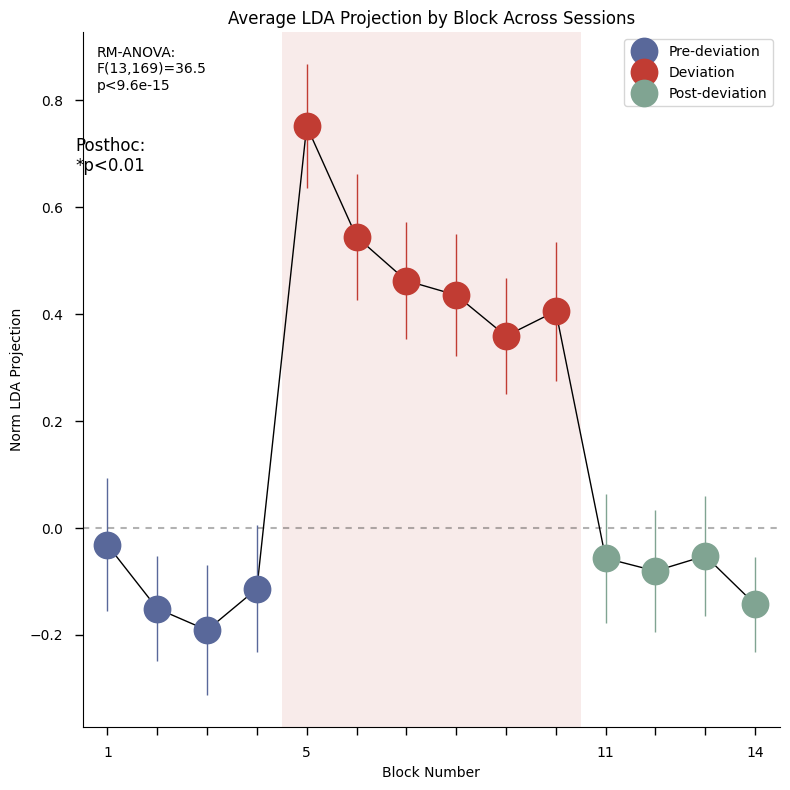

In [8]:
def plot_sum_session_lda_blocks(projections_list, dev_on_frames_list, reach_mask_list, 
                          block_size=10, n_reach_trials=140, 
                          fp_frame_num_2p = FP_FRAME_NUM_2P):
    """Plot concatenated LDA blocks for each session vertically and their summary"""
    n_sessions = len(projections_list)
    n_blocks = n_reach_trials // block_size
    session_block_metric = []  # List to store block metrics for each session
    
    # Calculate block metrics for each session
    for sess_idx, (projections, dev_on_frames, reach_mask) in enumerate(zip(
            projections_list, dev_on_frames_list, reach_mask_list)):
        
        # Get reach trials only
        reach_data = projections[reach_mask]
        
        # Calculate perturbation onset and window
        pert_onset = int(np.nanmean(dev_on_frames[~np.isnan(dev_on_frames)]))
        window = slice(pert_onset, pert_onset + fp_frame_num_2p)
        
        # Calculate block metrics for this session
        sess_block_means = []
        for i in range(n_blocks):
            start_trial = i * block_size
            end_trial = min((i + 1) * block_size, n_reach_trials)
            
            # Get block data
            block_data = reach_data[start_trial:end_trial]
            
            # Calculate mean
            block_mean = np.nanmean(block_data[:, window], axis=0)
            # # Find peak index based on absolute value
            # peak_idx = np.nanargmax(np.abs(block_mean))
            # # Get actual value at peak index
            # peak_value = block_mean[peak_idx]
            # sess_block_means.append(peak_value)
            sess_block_means.append(np.nanmean(block_mean))
            
        # Normalize by peak
        sess_block_means = np.array(sess_block_means)
        norm_factor = np.nanmax(np.abs(sess_block_means))
        sess_block_means = sess_block_means/norm_factor
        
        session_block_metric.append(sess_block_means)
    
    # Convert to numpy array for easier calculations
    session_block_metric = np.array(session_block_metric)
    
    # Create summary plot
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot individual session data
    block_numbers = np.arange(1, n_blocks + 1)
    # for sess_idx in range(n_sessions):
    #     ax.plot(block_numbers, session_block_metric[sess_idx], 
    #             alpha=0.3, color='#a4aca7', marker='', linestyle='-')
    
    # Calculate and plot mean ± SEM across sessions
    mean_across_sessions = np.nanmean(session_block_metric, axis=0)
    valid_counts = np.sum(~np.isnan(session_block_metric), axis=0)
    sem_across_sessions = np.nanstd(session_block_metric, axis=0) / np.sqrt(valid_counts)
    
    # ax.errorbar(block_numbers, mean_across_sessions, 
    #             yerr=sem_across_sessions,
    #             color='black', linewidth=1, 
    #             marker='o', markersize=24,
    #             # markerfacecolor='none',  # Make marker transparent
    #             markeredgewidth=2,       # Set marker edge width
    #             capsize=0,              # Remove caps
    #             label='Mean across sessions',
    #             elinewidth=1)

    # Define block ranges
    pre_dev_blocks = np.arange(1, 5)  # First 4 blocks
    dev_blocks = np.arange(5, 11)     # Next 6 blocks
    post_dev_blocks = np.arange(11, 15)  # Last 4 blocks

    # Colors for different phases
    colors = {
        'pre_dev': '#59689a',         # DarkSeaGreen
        'dev': '#C13C33',            # Rich crimson red
        'post_dev': '#80A492',      # piaolv
    }

    # First plot the connected average line across all blocks
    all_blocks = np.arange(1, 15)
    ax.plot(all_blocks, mean_across_sessions, 
            color='black', linewidth=1, zorder=1)

    # Then plot error bars for each phase with markers but no connecting lines
    ax.errorbar(pre_dev_blocks, mean_across_sessions[pre_dev_blocks-1], 
                yerr=sem_across_sessions[pre_dev_blocks-1],
                fmt='o',  # Keep marker, remove line
                color=colors['pre_dev'], 
                markersize=18,
                # markerfacecolor='none',
                markeredgewidth=2,
                capsize=0,
                elinewidth=1,
                label='Pre-deviation',
                zorder=2)

    ax.errorbar(dev_blocks, mean_across_sessions[dev_blocks-1], 
                yerr=sem_across_sessions[dev_blocks-1],
                fmt='o',  # Keep marker, remove line
                color=colors['dev'], 
                markersize=18,
                # markerfacecolor='none',
                markeredgewidth=2,
                capsize=0,
                elinewidth=1,
                label='Deviation',
                zorder=2)

    ax.errorbar(post_dev_blocks, mean_across_sessions[post_dev_blocks-1], 
                yerr=sem_across_sessions[post_dev_blocks-1],
                fmt='o',  # Keep marker, remove line
                color=colors['post_dev'], 
                markersize=18,
                # markerfacecolor='none',
                markeredgewidth=2,
                capsize=0,
                elinewidth=1,
                label='Post-deviation',
                zorder=2)
    
    ax.axhline(y=0, color='k', linestyle='--', dashes = (3,3), alpha=0.3)

    # Add rectangle for deviation period
    ylim = ax.get_ylim()
    rect = plt.Rectangle((4.5, ylim[0]), 6, ylim[1]-ylim[0],
                        facecolor=colors['dev'],
                        alpha=0.1,
                        zorder=0)  # Put rectangle behind other elements
    ax.add_patch(rect)


    # Set specific x-ticks
    ax.set_xticks([1, 5, 11, 14])  # Show only these block numbers
    ax.set_xticklabels([1, 5, 11, 14])  # Use same numbers for labels
    ax.tick_params(axis='both', which='major', direction='out', 
                  length=6, width=1, pad=8)
    # Ensure ticks extend across full range
    ax.set_xlim(0.5, 14.5)  # Add some padding on both ends
    # Reset ylim after adding rectangle
    ax.set_ylim(ylim)

    # Customize plot
    ax.set_xlabel('Block Number')
    ax.set_ylabel('Norm LDA Projection')
    ax.set_title('Average LDA Projection by Block Across Sessions')
    # ax.grid(True, alpha=0.3)
    ax.legend()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Set x-axis to show all block numbers
    ax.set_xticks(block_numbers)
    
    plt.tight_layout()


    # Prepare data for repeated measures ANOVA
    data_long = []
    for sess_idx in range(n_sessions):
        for block_idx in range(n_blocks):
            data_long.append({
                'Session': sess_idx,
                'Block': block_idx + 1,
                'Value': session_block_metric[sess_idx, block_idx]
            })
    
    df = pd.DataFrame(data_long)
    
    # Perform repeated measures ANOVA
    rm_anova = pg.rm_anova(data=df, dv='Value', within='Block', subject='Session', correction=True)
    print("\nRepeated Measures ANOVA Results:")
    print(rm_anova)

    # Add ANOVA results text
    anova_text = f"RM-ANOVA:\nF({rm_anova['ddof1'].iloc[0]},{rm_anova['ddof2'].iloc[0]})={rm_anova['F'].iloc[0]:.1f}\np<{rm_anova['p-GG-corr'].iloc[0]:.1e}"
    ax.text(0.02, 0.98, anova_text,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    # Perform post-hoc if ANOVA is significant
    if rm_anova.loc[rm_anova['Source'] == 'Block', 'p-unc'].values[0] < 0.05:
        # Perform pairwise tests with FDR correction using updated function
        post_hoc = pg.pairwise_tests(data=df, 
                                    dv='Value',
                                    within='Block', 
                                    subject='Session',
                                    parametric=True,
                                    padjust='fdr_bh')
        
        # Print significant comparisons with perturbed blocks (blocks 5-10)
        print("\nSignificant Post-hoc Comparisons (vs Perturbed Blocks):")
        pert_blocks = set(range(5, 11))
        
        for _, row in post_hoc.iterrows():
            A = int(row['A'])
            B = int(row['B'])
            if row['p-corr'] < 0.05 and (A in pert_blocks or B in pert_blocks):
                mean_diff = df[df['Block'] == A]['Value'].mean() - df[df['Block'] == B]['Value'].mean()
                print(f"Block {A} vs Block {B}: diff = {mean_diff:.3f}, p = {row['p-corr']:.3f}")
        
        # Add significance markers to plot if any comparisons are significant
        if (post_hoc['p-corr'] < 0.01).any():
            ax.text(0.09, 0.85, 'Posthoc:\n*p<0.01', transform=ax.transAxes, 
                fontsize=12, ha='right', va='top')

    return fig, ax, session_block_metric, (rm_anova, post_hoc if 'post_hoc' in locals() else None)

# Modified plotting call
if valid_sessions > 0:
    fig_blocks, ax_blocks, block_metrics, stats_results = plot_sum_session_lda_blocks(
        projections_list, 
        dev_on_frames_list,
        reach_mask_list,
        block_size=BLOCK_SIZE,
        n_reach_trials=REACH_TRIALS_PER_SESSION,
        fp_frame_num_2p=FP_FRAME_NUM_2P
    )
    plt.savefig(f'{NAME_KEY}_Session_LDA_Blocks_Lineplot_Summary_Spks.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [9]:
# Initialize collections
projections_list = []
residual_projections_list = []  # New list for residual projections
dev_on_frames_list = []
reach_mask_list = []

# Process each session
valid_sessions = 0

for session_idx, (session_key, result) in enumerate(results.items()):
    signal_input = result['spks_align']  # Assuming spks_align is the signal input
    tmp_n_neurons = signal_input.shape[0]

    if tmp_n_neurons > N_COMP:
        print(f'Processing session: {session_key}')
        dev_on_frames_2p = result['dev_on_frames_2p']

        # Prepare data
        full_mat_info = np.transpose(signal_input[:,:,:], (1, 2, 0))
        n_trials, n_frames, n_features = full_mat_info.shape
        trial_sess_id = np.zeros(n_trials)
        tmp_dev_on_frames_2p = dev_on_frames_2p[:n_trials]
        reach_mask = np.zeros_like(tmp_dev_on_frames_2p, dtype=bool)
        reach_mask[:REACH_TRIALS_PER_SESSION] = True  # First 140 trials are reach trials  

        # Compute PCA projections
        pca_projections, var_expalained = compute_pca_projections(full_mat_info, n_pca_components=N_COMP)

        # Compute both LDA projection and CV-averaged residual projection in one call
        projections, residual_projections, lda_weights, lda_models = compute_lda_and_residual_projection(
            pca_projections=pca_projections,
            dev_on_frames=dev_on_frames_2p,
            trial_sess_id=trial_sess_id,
            n_comps=N_COMP,
            fp_frame_num=FP_FRAME_NUM_2P,
            cv_num=10,
            reach_trials_per_session=REACH_TRIALS_PER_SESSION
        )

        # Append to lists
        projections_list.append(projections)
        residual_projections_list.append(residual_projections)
        dev_on_frames_list.append(dev_on_frames_2p)
        reach_mask_list.append(reach_mask)

        valid_sessions += 1

print(f"\nProcessed {valid_sessions} valid sessions")

Processing session: Fezf2GC8#329M_WR_Pos340_2X_Adaptation_Passive_Limb_LED_Stim_10Hz2s_From_Lift_6
Using first 4 components out of 4 based on variance threshold
Processing session: Fezf2GC8#329M_WR_Pos370_2X_Adaptation_Passive_Limb_LED_Stim_10Hz2s_From_Lift_3
Using first 4 components out of 4 based on variance threshold
Processing session: Fezf2GC8#329M_WR_Pos446_2X_Adaptation_Passive_Limb_LED_Stim_10Hz2s_From_Lift_7
Using first 4 components out of 4 based on variance threshold
Processing session: Fezf2GC8#329M_WR_Pos460_2X_Adaptation_Passive_Limb_LED_Stim_10Hz2s_From_Lift_4
Using first 4 components out of 4 based on variance threshold
Processing session: Fezf2GC8#329M_WR_Pos500_2X_Adaptation_Passive_Limb_LED_Stim_10Hz2s_From_Lift_5
Using first 4 components out of 4 based on variance threshold
Processing session: Fezf2GC8#329M_WR_Pos520_2X_Adaptation_Passive_Limb_LED_Stim_10Hz2s_From_Lift_8
Using first 4 components out of 4 based on variance threshold
Processing session: Fezf2GC8#332M_


Repeated Measures ANOVA Results:
  Source  ddof1  ddof2          F         p-unc     p-GG-corr       ng2  \
0  Block     13    169  36.490715  2.827258e-42  9.608408e-15  0.342829   

        eps  sphericity   W-spher  p-spher  
0  0.313314        True  0.048905      1.0  

Significant Post-hoc Comparisons (vs Perturbed Blocks):
Block 1 vs Block 5: diff = -0.783, p = 0.000
Block 1 vs Block 6: diff = -0.576, p = 0.000
Block 1 vs Block 7: diff = -0.494, p = 0.000
Block 1 vs Block 8: diff = -0.467, p = 0.000
Block 1 vs Block 9: diff = -0.391, p = 0.003
Block 1 vs Block 10: diff = -0.437, p = 0.000
Block 2 vs Block 5: diff = -0.902, p = 0.000
Block 2 vs Block 6: diff = -0.695, p = 0.000
Block 2 vs Block 7: diff = -0.613, p = 0.000
Block 2 vs Block 8: diff = -0.586, p = 0.000
Block 2 vs Block 9: diff = -0.510, p = 0.000
Block 2 vs Block 10: diff = -0.556, p = 0.000
Block 3 vs Block 5: diff = -0.942, p = 0.000
Block 3 vs Block 6: diff = -0.736, p = 0.000
Block 3 vs Block 7: diff = -0.653, p

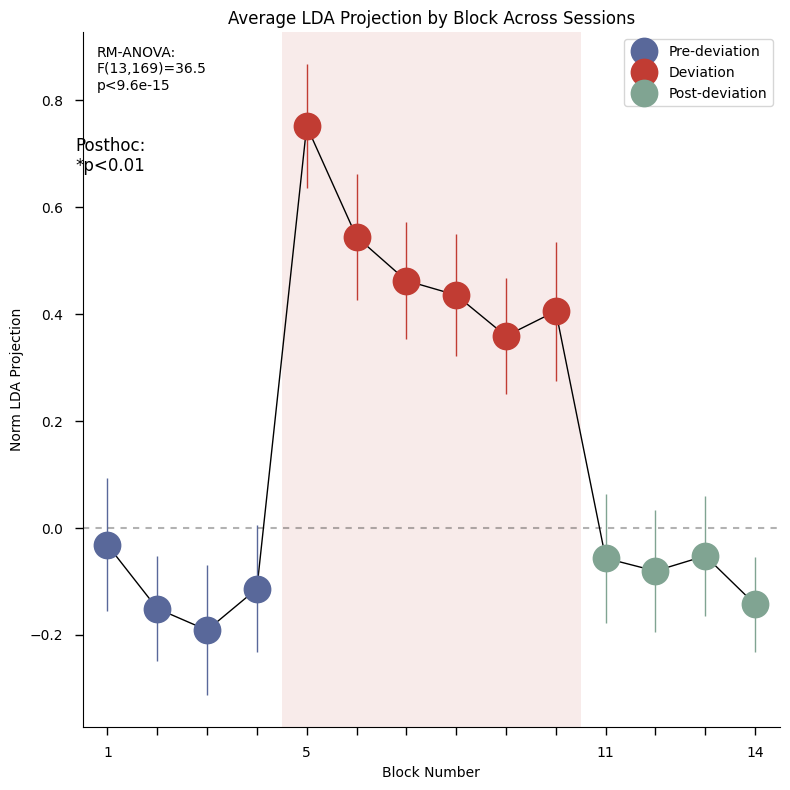


Repeated Measures ANOVA Results:
  Source  ddof1  ddof2         F     p-unc  p-GG-corr       ng2       eps  \
0  Block     13    169  0.831523  0.626316   0.535468  0.019717  0.399055   

   sphericity   W-spher   p-spher  
0        True  0.000391  1.018846  


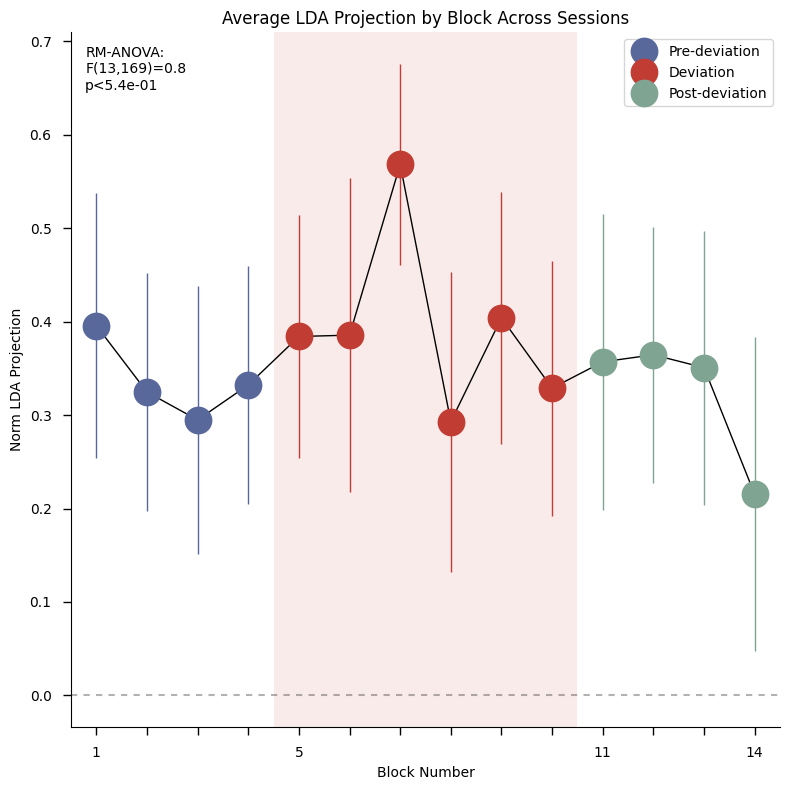

In [10]:
# Modified plotting call for residual projections
if valid_sessions > 0:
    fig_blocks, ax_blocks, block_metrics, stats_results = plot_sum_session_lda_blocks(
        projections_list, 
        dev_on_frames_list,
        reach_mask_list,
        block_size=BLOCK_SIZE,
        n_reach_trials=REACH_TRIALS_PER_SESSION,
        fp_frame_num_2p=FP_FRAME_NUM_2P
    )
    # plt.savefig('Fezf2_Session_LDA_Blocks_Lineplot_Summary_Spks.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.show()

    # Plot residual projections the same way (if computed)
    if len(residual_projections_list) == len(projections_list) and len(residual_projections_list) > 0:
        fig_res, ax_res, block_metrics_res, stats_res_res = plot_sum_session_lda_blocks(
            residual_projections_list,
            dev_on_frames_list,
            reach_mask_list,
            block_size=BLOCK_SIZE,
            n_reach_trials=REACH_TRIALS_PER_SESSION,
            fp_frame_num_2p=FP_FRAME_NUM_2P
        )
        plt.savefig(f'{NAME_KEY}_Session_Residual_Projection_Blocks_Summary_Spks.pdf',
                    format='pdf', bbox_inches='tight', dpi=300)
        plt.show()